In [1]:
%matplotlib inline

# Deep Learning for Emotions Recognition

## FER dataset

> The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

*Source: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data*

We load FER data as numpy arrays (data and targets). You can find parsing function in `utils/ferloader.py`. It can also load dataset from numpy archive. Data was parsed and packed in numpy archive before, so we can load it now.

## Train/Test division

In this dataset you can find 35,887 face images. It is divided into train and test sets, 30503 and 5384 images respectively. Test set is used to evaluate our overall performance after training. Data is split in a **stratified fashion**, using class labels as distribution.

## One-hot vector

Target emotions are transformed to one-hot vectors. One-hot vector is a vector with all '0' but one '1' at emotion index.

![one-hot vectors](refs/one-hot_vectors.jpg)

In [ ]:
from keras.backend import image_data_format, clear_session
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

from sklearn import datasets
from sklearn.cross_validation import train_test_split

from utils.ferloader import load_fer

from random import uniform

import matplotlib.pyplot as plt
# Set bigger figures
plt.rcParams["figure.figsize"] = (15, 15)

import os.path

# Constants
IMAGE_WIDTH = 48
IMAGE_HEIGHT = 48
EMOTIONS = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
DATA_FORMAT = image_data_format()

# Prepare data
data, target = load_fer("data/fer2013.npz")
data_train, data_test, target_train, target_test = \
  train_test_split(data, target, test_size=0.15, random_state=7, stratify=target)
_, n_features = data.shape

# Prepare targets
onehot_train = to_categorical(target_train)
onehot_test = to_categorical(target_test)

## Data inspection

It is always worth to look at your date to understand it. Below we print 25 faces from our test set with corresponding label above each one. **Would you classify every image shown as ground truth label says?**

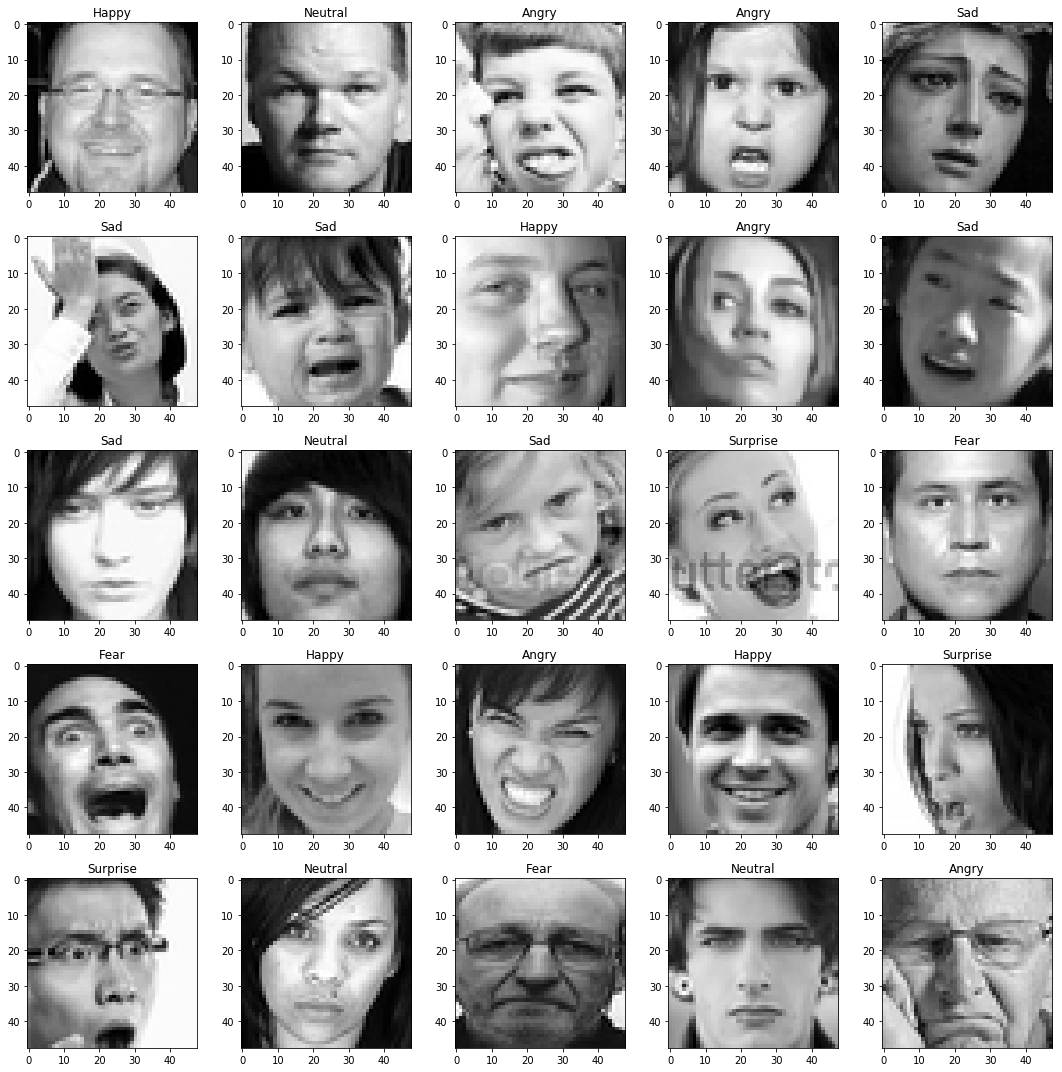

In [3]:
# Visualize data
for i, (image, label) in enumerate(zip(data_test[:25, :], target_test[:25])):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.reshape((IMAGE_HEIGHT, IMAGE_WIDTH)), cmap=plt.cm.gray)
    plt.title(EMOTIONS[label])
# Make more space between subplots
plt.tight_layout()
plt.show()

## Build neural network model

Before we'll dive into code, let's briefly introduce layers we use.

### Dense

![fully connected](refs/fully_connected_layer.png)

In dense layer (fully connected) **each neuron is connected to every neuron in previous layer**. Because of that, we can get many many weights while processing high-dimensional input (like image) and it can be undesired. Dense layers more often are used at the end of the neural network model as classifiers. This classifier makes it's decision based on features extracted by convolutional layers. 

In [4]:
help(Dense)

Help on class Dense in module keras.layers.core:

class Dense(keras.engine.topology.Layer)
 |  Just your regular densely-connected NN layer.
 |  
 |  `Dense` implements the operation:
 |  `output = activation(dot(input, kernel) + bias)`
 |  where `activation` is the element-wise activation function
 |  passed as the `activation` argument, `kernel` is a weights matrix
 |  created by the layer, and `bias` is a bias vector created by the layer
 |  (only applicable if `use_bias` is `True`).
 |  
 |  Note: if the input to the layer has a rank greater than 2, then
 |  it is flattened prior to the initial dot product with `kernel`.
 |  
 |  # Example
 |  
 |  ```python
 |      # as first layer in a sequential model:
 |      model = Sequential()
 |      model.add(Dense(32, input_shape=(16,)))
 |      # now the model will take as input arrays of shape (*, 16)
 |      # and output arrays of shape (*, 32)
 |  
 |      # after the first layer, you don't need to specify
 |      # the size of the in

### Dropout

The thing is, when we have a lot of weights it is **very likely that our network will overfit**. Thats why we use regularization methods like dropout.

![dropout](refs/dropout.jpeg)

> Figure taken from the Dropout paper that illustrates the idea. During training, Dropout can be interpreted as sampling a Neural Network within the full Neural Network, and only updating the parameters of the sampled network based on the input data. (However, the exponential number of possible sampled networks are not independent because they share the parameters.) During testing there is no dropout applied, with the interpretation of evaluating an averaged prediction across the exponentially-sized ensemble of all sub-networks.

In [5]:
help(Dropout)

Help on class Dropout in module keras.layers.core:

class Dropout(keras.engine.topology.Layer)
 |  Applies Dropout to the input.
 |  
 |  Dropout consists in randomly setting
 |  a fraction `rate` of input units to 0 at each update during training time,
 |  which helps prevent overfitting.
 |  
 |  # Arguments
 |      rate: float between 0 and 1. Fraction of the input units to drop.
 |      noise_shape: 1D integer tensor representing the shape of the
 |          binary dropout mask that will be multiplied with the input.
 |          For instance, if your inputs have shape
 |          `(batch_size, timesteps, features)` and
 |          you want the dropout mask to be the same for all timesteps,
 |          you can use `noise_shape=(batch_size, 1, features)`.
 |      seed: A Python integer to use as random seed.
 |  
 |  # References
 |      - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
 |  
 |  Method 

### Convolution

![convolution](refs/convolution.gif)

As we can see on the animation above, convolution layer is sliding filter across input volume (in this animation input is a 2D plane, but add depth to it in your imagination) in width and height dimensions. In depth dimension it always extends through the full depth of the input volume. As filter slides (convolve) it computes dot products between the entries of the filter and the input at any position.

**Local connectivity** of neurons means that each neuron is looking at some local region of input volume (determined by filter size). The spatial extent of this connectivity is a hyperparameter called the **receptive field** of the neuron.

**Spatial arrangement** of neurons consist of: depth of the output volume (filters number), the stride with which we slide the filter, zero-padding of input volume borders.

**Parameter sharing** of each output volume neuron is feasible, because we can expect the same patters showing up in different spatial localizations in the input.

### First conv layer weights visualization

![weights](refs/weights.jpeg)

Convolutional neural network builds more complicated abstractions with each deeper layer. You can see beautiful visualizations in this article: https://distill.pub/2017/feature-visualization/.

In [6]:
help(Conv2D)

Help on class Conv2D in module keras.layers.convolutional:

class Conv2D(_Conv)
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
 |  in `data_format="channels_last"`.
 |  
 |  # Arguments
 |      filters: Integer, the dimensionality of the output space
 |          (i.e. the number of output filters in the convolution).
 |      kernel_size: An integer or tuple/list of 2 integers, specifying the
 |          width and height of the 2D convolution window.
 |        

### Batch Normalization

![batch norm](refs/batch_norm_alg.png)

In short, we want each layer to be invariant to distribution shifts and scaling in previous layers. **It stabilize training.**

In [7]:
help(BatchNormalization)

Help on class BatchNormalization in module keras.layers.normalization:

class BatchNormalization(keras.engine.topology.Layer)
 |  Batch normalization layer (Ioffe and Szegedy, 2014).
 |  
 |  Normalize the activations of the previous layer at each batch,
 |  i.e. applies a transformation that maintains the mean activation
 |  close to 0 and the activation standard deviation close to 1.
 |  
 |  # Arguments
 |      axis: Integer, the axis that should be normalized
 |          (typically the features axis).
 |          For instance, after a `Conv2D` layer with
 |          `data_format="channels_first"`,
 |          set `axis=1` in `BatchNormalization`.
 |      momentum: Momentum for the moving mean and the moving variance.
 |      epsilon: Small float added to variance to avoid dividing by zero.
 |      center: If True, add offset of `beta` to normalized tensor.
 |          If False, `beta` is ignored.
 |      scale: If True, multiply by `gamma`.
 |          If False, `gamma` is not used

### Max pooling

![maxpool](refs/maxpool.jpeg)

Max pooling function progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.

In [8]:
help(MaxPooling2D)

Help on class MaxPooling2D in module keras.layers.pooling:

class MaxPooling2D(_Pooling2D)
 |  Max pooling operation for spatial data.
 |  
 |  # Arguments
 |      pool_size: integer or tuple of 2 integers,
 |          factors by which to downscale (vertical, horizontal).
 |          (2, 2) will halve the input in both spatial dimension.
 |          If only one integer is specified, the same window length
 |          will be used for both dimensions.
 |      strides: Integer, tuple of 2 integers, or None.
 |          Strides values.
 |          If None, it will default to `pool_size`.
 |      padding: One of `"valid"` or `"same"` (case-insensitive).
 |      data_format: A string,
 |          one of `channels_last` (default) or `channels_first`.
 |          The ordering of the dimensions in the inputs.
 |          `channels_last` corresponds to inputs with shape
 |          `(batch, height, width, channels)` while `channels_first`
 |          corresponds to inputs with shape
 |         

### Reshape and flatten

You can control data shape in neural network with those two layers. You will most often use `Flatten()` before first dense layer and `Reshape(...)` before first conv layer.

In [9]:
help(Reshape)

Help on class Reshape in module keras.layers.core:

class Reshape(keras.engine.topology.Layer)
 |  Reshapes an output to a certain shape.
 |  
 |  # Arguments
 |      target_shape: target shape. Tuple of integers.
 |          Does not include the batch axis.
 |  
 |  # Input shape
 |      Arbitrary, although all dimensions in the input shaped must be fixed.
 |      Use the keyword argument `input_shape`
 |      (tuple of integers, does not include the batch axis)
 |      when using this layer as the first layer in a model.
 |  
 |  # Output shape
 |      `(batch_size,) + target_shape`
 |  
 |  # Example
 |  
 |  ```python
 |      # as first layer in a Sequential model
 |      model = Sequential()
 |      model.add(Reshape((3, 4), input_shape=(12,)))
 |      # now: model.output_shape == (None, 3, 4)
 |      # note: `None` is the batch dimension
 |  
 |      # as intermediate layer in a Sequential model
 |      model.add(Reshape((6, 2)))
 |      # now: model.output_shape == (None, 6, 2)


In [10]:
help(Flatten)

Help on class Flatten in module keras.layers.core:

class Flatten(keras.engine.topology.Layer)
 |  Flattens the input. Does not affect the batch size.
 |  
 |  # Example
 |  
 |  ```python
 |      model = Sequential()
 |      model.add(Conv2D(64, 3, 3,
 |                       border_mode='same',
 |                       input_shape=(3, 32, 32)))
 |      # now: model.output_shape == (None, 64, 32, 32)
 |  
 |      model.add(Flatten())
 |      # now: model.output_shape == (None, 65536)
 |  ```
 |  
 |  Method resolution order:
 |      Flatten
 |      keras.engine.topology.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  call(self, inputs)
 |      This is where the layer's logic lives.
 |      
 |      # Arguments
 |          inputs: Input tensor, or list/tuple of input tensors.
 |          **kwargs: Additional keyword arguments.
 |      
 |      # Returns
 |     

### Implement model

Your task is to implement this model architecture:

```
Layer (type)                 Output Shape              Param #   
=================================================================
reshape_1 (Reshape)          (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 96)        153696    
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 96)        384       
_________________________________________________________________
activation_3 (Activation)    (None, 12, 12, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 96)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3539968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 7175      
=================================================================
Trainable params: 3,805,415
```

In [ ]:
def conv2d_n_batchnorm(model, filters):
    # TODO: Add Conv2d layer
    model.add( ... )
    # Depending on data layout of our backend,
    # we point to different axis as channel dim.
    if DATA_FORMAT == 'channels_first':
        model.add(BatchNormalization(axis=1))
    else:
        model.add(BatchNormalization(axis=3))
    # TODO: Add activation
    model.add(Activation( ... ))
    # TODO: Add max pooling
    model.add( ... )

model = Sequential()
# Depending on data layout of our backend,
# we point to different axis as channel dim.
if DATA_FORMAT == 'channels_first':
    model.add(Reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH), input_shape=(n_features,)))
else:
    model.add(Reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 1), input_shape=(n_features,)))

# TODO: Add "conv2d and batch normalization" layers
...

# TODO: Add classifier
...

## Loss function

We need to measure how bad we are to get better. For classification problem we often interpret neural network output as unnormalized log probability of each class. We calculate probabilities from it with softmax function:

![softmax](refs/softmax.svg)

Then we use cross-entropy, to calculate how two distributions (predictions and targets) differ:

![cross entropy](refs/cross_entropy.svg)

## Gradient decent

When we know what is net loss, we now want to change each parameter in such a way, that will decrease its error. What tells us how to change parameters is gradient. As we change our parameters in the opposite direction to the gradient, we decrease loss. This algorithm is called gradient decent and it's very similar to blindly wandering in the mountains, looking for valley.

![gradient decent](refs/grad_descent_mountain.png)

## Optimizer

Computing gradient is not enough, we need to apply it somewhat. There are different ways to do this, one of them is momentum which we use.

### Learning rate

Learning rate tells us how big update should be: $w = w - \alpha * grad$.

![learning rate](refs/learning_rate.png)

### Momentum

Momentum simulates inertia of update: $v = \mu * v' - \alpha * grad, w = w + v$. With Momentum update, the parameter vector will build up velocity in any direction that has consistent gradient.

### Decay

In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function.

* Step decay: Reduce the learning rate by some factor every few epochs. Typical values might be reducing the learning rate by a half every 5 epochs, or by 0.1 every 20 epochs. These numbers depend heavily on the type of problem and the model. One heuristic you may see in practice is to watch the validation error while training with a fixed learning rate, and reduce the learning rate by a constant (e.g. 0.5) whenever the validation error stops improving.
* Exponential decay: It has the mathematical form $\alpha = \alpha_0e^{-kt}$, where $a_0, k$ are hyperparameters and $t$ is the iteration number (but you can also use units of epochs).
* $1/t$ decay has the mathematical form $\alpha = \alpha_0/(1+kt)$ where $a_0, k$ are hyperparameters and $t$ is the iteration number.

In [11]:
help(SGD)

Help on class SGD in module keras.optimizers:

class SGD(Optimizer)
 |  Stochastic gradient descent optimizer.
 |  
 |  Includes support for momentum,
 |  learning rate decay, and Nesterov momentum.
 |  
 |  # Arguments
 |      lr: float >= 0. Learning rate.
 |      momentum: float >= 0. Parameter that accelerates SGD
 |          in the relevant direction and dampens oscillations.
 |      decay: float >= 0. Learning rate decay over each update.
 |      nesterov: boolean. Whether to apply Nesterov momentum.
 |  
 |  Method resolution order:
 |      SGD
 |      Optimizer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, lr=0.01, momentum=0.0, decay=0.0, nesterov=False, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_config(self)
 |  
 |  get_updates(self, loss, params)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Optimizer:
 |  
 |  get_gradients(self, 

In [ ]:
# TODO: Add 'nesterov' momentum optimizer with:
# Learning rate = 0.008
#      Momentum = 0.43
#         Decay = 0.00023
momentum_opt = ...

# TODO: Compile model, use categorical crossentropy loss, momentum optimizer and accuracy metric
model.compile( ... )

## Callbacks

It's possible to monitor and control training process via Keras callbacks:
* Model checkpoints - Save the model after every epoch, but only if given metric improves.
* TensorBoard - Log loss and accuracy on train and validation set to tensorboard. Also saves graph.
* EarlyStopping - Stop training after n epochs without improvement of given metric.

In [ ]:
callbacks_list = [
    ModelCheckpoint(os.path.join("./checkpoints/current_model.hdf5"), monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    TensorBoard(log_dir="./logs/current_run"),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
] 

## Training

Use `model.fit(...)` method to train model for 100 epochs at max. Use validation split of 0.15.

In [ ]:
model.fit( ... )

## Evaluate model

Use `model.evaluate(...)` and `model.predict(...)` methods to evaluate model and print example images.

In [ ]:
# Load best model
model.load_weights("./checkpoints/best_model.hdf5")

# TODO: Evaluate best model
results = model.evaluate( ... )
print("\n[!] Evaluation results:")
print("{0}: {2:.3f}, {1}: {3:.3f}".format(*model.metrics_names, *results))
    
# TODO: Predict subset of faces
preds = model.predict( ... )

# Visualize example data
for i, (image, label, pred) in enumerate(zip(data_test[:25, :], target_test[:25], preds)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.reshape((IMAGE_HEIGHT, IMAGE_WIDTH)), cmap=plt.cm.gray)
    plt.title("{} ({})".format(EMOTIONS[pred.argmax()], EMOTIONS[label]))
# Make more space between subplots
plt.tight_layout()
plt.show()

## Clean up!

In [ ]:
del model
clear_session()

**Further study:**
* [Short introduction to ANNs by 3Blue1Brown](http://3b1b.co/neural-networks)
* [Convolutional Neural Networks for Visual Recognition](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC)
* [Deep Learning.ai](https://www.coursera.org/specializations/deep-learning)
* [Fast.ai](http://www.fast.ai/)

**Sources:**
* http://cs231n.github.io/
* https://medium.com/@Synced/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-42f33d4378e0
* http://sciagaprogramisty.blogspot.com/2018/03/fully-connected-layer-fc-warstwa-w-peni.html